In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
!pip install scikit-learn


In [3]:
import shutil
import random


In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader


In [5]:
import torch
import torch.nn as nn
from torchvision import models

In [6]:
!pip install scikit-learn


In [7]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score
import torch.nn.functional as F

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
import numpy as np

# Data Loading

In [10]:
train_dir = '/kaggle/input/chest-xray-pneumonia/'
val_dir = '/kaggle/input/chest-xray-pneumonia/'
test_dir = '/kaggle/input/chest-xray-pneumonia/'

In [11]:
chest_xray_dir = os.path.join(train_dir, 'chest_xray')


In [12]:
train_dir = os.path.join(chest_xray_dir, 'train')
val_dir = os.path.join(chest_xray_dir, 'val')
test_dir = os.path.join(chest_xray_dir, 'test')

# Functions

In [13]:
def plot_class_distribution(data, title):
    classes = list(data.keys())
    counts = list(data.values())
    
    plt.figure(figsize=(6, 4))
    plt.bar(classes, counts, color=['blue', 'orange'])
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Número de Imagens')
    plt.show()

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    history = {'train_loss': [], 'val_loss': [],
               'train_accuracy': [], 'val_accuracy': [],
               'train_f1': [], 'val_f1': [],
               'train_precision': [], 'val_precision': [],
               'train_recall': [], 'val_recall': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)
        
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        train_loss = running_loss / len(train_loader)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_precision = precision_score(all_labels, all_preds, average='weighted')
        train_recall = recall_score(all_labels, all_preds, average='weighted')
        train_accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).sum().item() / len(all_labels)
        
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_f1'].append(train_f1)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)

        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
        
        val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
        val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
        val_accuracy = (torch.tensor(all_val_preds) == torch.tensor(all_val_labels)).sum().item() / len(all_val_labels)
        
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)

        print(f'Treino: Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1-score: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}')
        print(f'Validação: Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1-score: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}')
        print()
    
    return history

In [15]:
def evaluate_model_on_test(model, test_loader, criterion, device='cpu'):
    model.eval()  
    
    test_loss = 0.0
    all_test_preds = []
    all_test_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader)
    test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')
    test_precision = precision_score(all_test_labels, all_test_preds, average='weighted')
    test_recall = recall_score(all_test_labels, all_test_preds, average='weighted')
    test_accuracy = (torch.tensor(all_test_preds) == torch.tensor(all_test_labels)).sum().item() / len(all_test_labels)

    print(f'Teste: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1-score: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')
    
    return test_loss, test_accuracy, test_f1, test_precision, test_recall

In [16]:
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Treino Loss')
    plt.plot(epochs, history['val_loss'], label='Validação Loss')
    plt.title('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history['train_accuracy'], label='Treino Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validação Accuracy')
    plt.title('Acurácia')
    plt.legend()

    # F1-Score
    plt.subplot(2, 3, 3)
    plt.plot(epochs, history['train_f1'], label='Treino F1-Score')
    plt.plot(epochs, history['val_f1'], label='Validação F1-Score')
    plt.title('F1-Score')
    plt.legend()

    # Precision
    plt.subplot(2, 3, 4)
    plt.plot(epochs, history['train_precision'], label='Treino Precision')
    plt.plot(epochs, history['val_precision'], label='Validação Precision')
    plt.title('Precision')
    plt.legend()

    # Recall
    plt.subplot(2, 3, 5)
    plt.plot(epochs, history['train_recall'], label='Treino Recall')
    plt.plot(epochs, history['val_recall'], label='Validação Recall')
    plt.title('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [17]:
def evaluate_and_plot_confusion_matrix(model, test_loader, device='cpu'):
    model.eval()  
    all_test_preds = []
    all_test_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_test_labels, all_test_preds)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix - Test Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [18]:
def plot_confusion_matrix_validation(model, val_loader, device='cpu'):
    model.eval()  
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_val_labels, all_val_preds)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix - Validation Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [19]:
def show_images(dataset_dir, class_name, num_images=5):
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)[:num_images]
    
    plt.figure(figsize=(12, 6))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.show()

In [20]:
def plot_histogram_of_intensities(dataset_dir, class_name, num_images=5):
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)[:num_images]
    
    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).convert('L')  
        img_np = np.array(img).flatten()  
        
        plt.subplot(1, num_images, i + 1)
        plt.hist(img_np, bins=50, color='blue', alpha=0.7)
        plt.title(f'Histograma - {class_name} {i+1}')
        plt.xlabel('Valor de Pixel')
        plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()

# EDA

In [21]:
train_classes = os.listdir(train_dir)
val_classes = os.listdir(val_dir)
test_classes = os.listdir(test_dir)

In [22]:
print(f'Classes in training: {train_classes}')
print(f'Classes em validation: {val_classes}')
print(f'Classes em test: {test_classes}')

Classes in training: ['PNEUMONIA', 'NORMAL']
Classes em validation: ['PNEUMONIA', 'NORMAL']
Classes em test: ['PNEUMONIA', 'NORMAL']


In [23]:
train_count = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in train_classes}
val_count = {cls: len(os.listdir(os.path.join(val_dir, cls))) for cls in val_classes}
test_count = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in test_classes}


In [24]:
print(f'Training: {train_count}')
print(f'Validation: {val_count}')
print(f'Test: {test_count}')

Training: {'PNEUMONIA': 3875, 'NORMAL': 1341}
Validation: {'PNEUMONIA': 8, 'NORMAL': 8}
Test: {'PNEUMONIA': 390, 'NORMAL': 234}


In [25]:
train_count = {'NORMAL': 1341, 'PNEUMONIA': 3875}  # Exemplo de contagem real
val_count = {'NORMAL': 8, 'PNEUMONIA': 8}  # Exemplo de contagem real
test_count = {'NORMAL': 234, 'PNEUMONIA': 390}  # Exemplo de contagem real


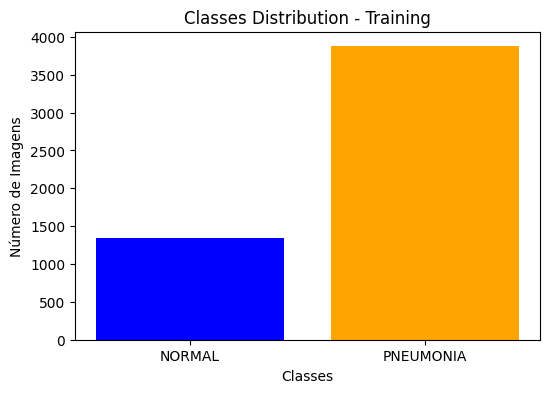

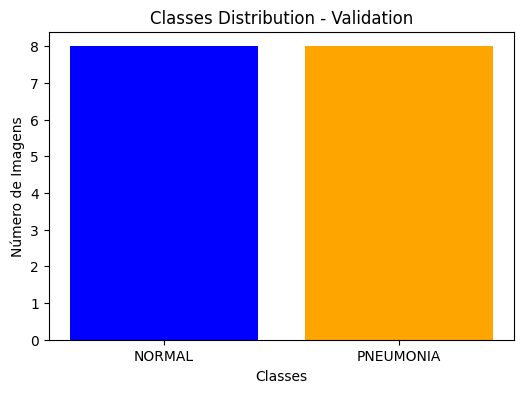

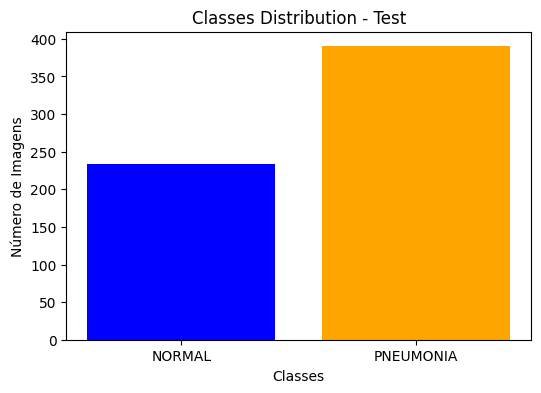

In [26]:
plot_class_distribution(train_count, 'Classes Distribution - Training')
plot_class_distribution(val_count, 'Classes Distribution - Validation')
plot_class_distribution(test_count, 'Classes Distribution - Test')

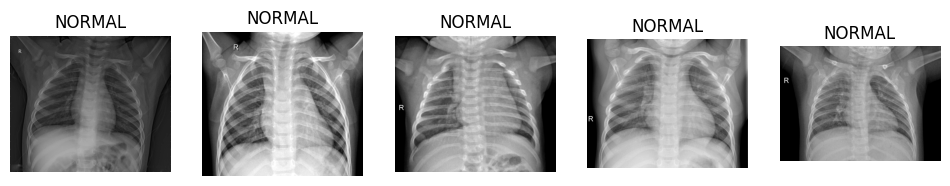

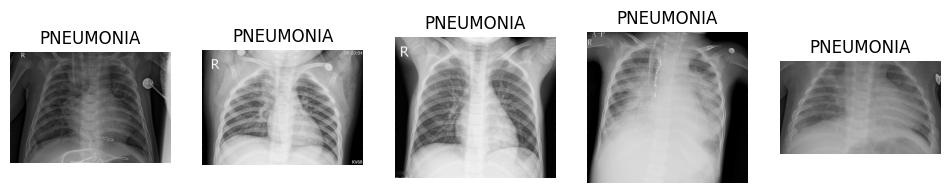

In [27]:
show_images(train_dir, 'NORMAL', num_images=5)
show_images(train_dir, 'PNEUMONIA', num_images=5)

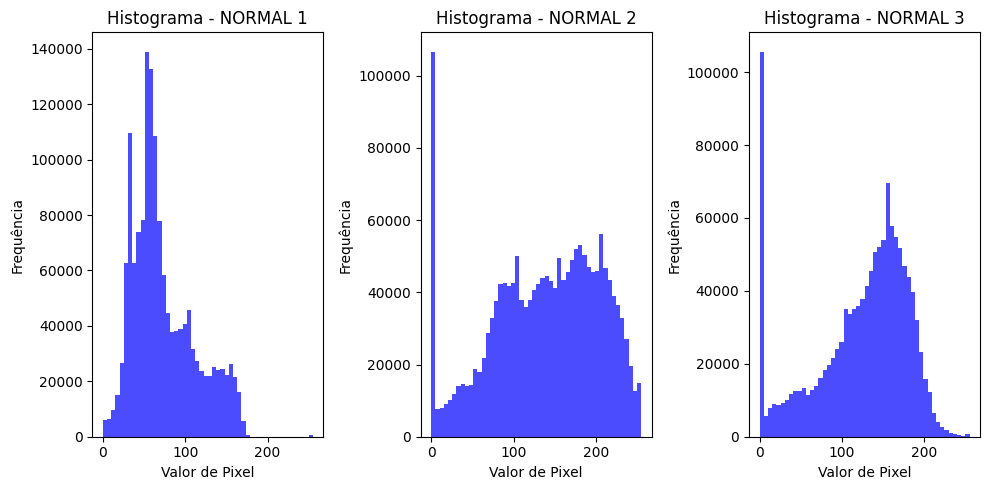

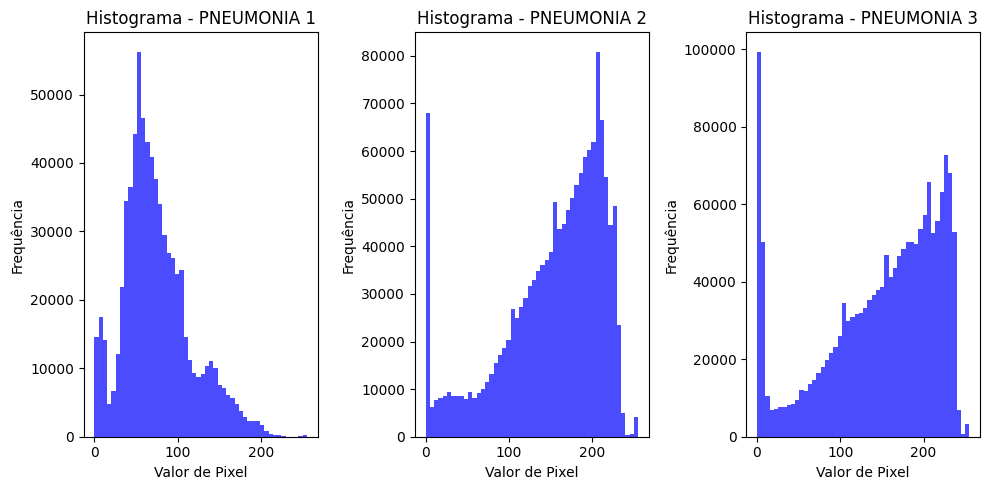

In [28]:
plot_histogram_of_intensities(train_dir, 'NORMAL', num_images=3)
plot_histogram_of_intensities(train_dir, 'PNEUMONIA', num_images=3)

# Pre-processing

I revised the validation set of the dataset because the original validation set only had 16 images, which was insufficient for evaluating the model effectively. A validation set with such a small number of samples could lead to unreliable metrics and poor generalization. To address this, I restructured the dataset by redistributing images from the training set to the validation set, ensuring that the validation process would be more accurate and robust.

In [29]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

In [30]:
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)


In [31]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

In [32]:
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])


In [33]:
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=True)


In [34]:
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [35]:
print(f'Training Size: {len(train_subset)}')
print(f'Validation Size: {len(val_subset)}')
print(f'Test Size: {len(test_dataset)}')

Training Size: 4172
Validation Size: 1044
Test Size: 624


# Model

In [36]:
class CustomDenseNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomDenseNet, self).__init__()
        
        self.densenet = models.densenet121(pretrained=True)
        
        for param in self.densenet.parameters():
            param.requires_grad = False
        
        num_ftrs = self.densenet.classifier.in_features
        
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),       
            nn.ReLU(),                       
            nn.Dropout(0.3),                 
            nn.Linear(512, 256),             
            nn.ReLU(),                       
            nn.BatchNorm1d(256),            
            nn.Linear(256, num_classes)      
        )
    
    def forward(self, x):
        x = self.densenet.features(x)
        x = nn.functional.relu(x, inplace=True)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        
        x = self.classifier(x)
        return x

In [37]:
num_classes = 2


In [38]:
model = CustomDenseNet(num_classes)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 133MB/s]


In [39]:
print(model)


CustomDenseNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [41]:
criterion = nn.CrossEntropyLoss()


In [42]:
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)


In [43]:
num_epochs = 10


In [44]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)


Epoch 1/10
--------------------
Treino: Loss: 0.2682, Accuracy: 0.8991, F1-score: 0.9016, Precision: 0.9085, Recall: 0.8991
Validação: Loss: 0.1863, Accuracy: 0.9425, F1-score: 0.9437, Precision: 0.9479, Recall: 0.9425

Epoch 2/10
--------------------
Treino: Loss: 0.1565, Accuracy: 0.9406, F1-score: 0.9405, Precision: 0.9405, Recall: 0.9406
Validação: Loss: 0.1152, Accuracy: 0.9492, F1-score: 0.9494, Precision: 0.9496, Recall: 0.9492

Epoch 3/10
--------------------
Treino: Loss: 0.1292, Accuracy: 0.9511, F1-score: 0.9509, Precision: 0.9508, Recall: 0.9511
Validação: Loss: 0.1328, Accuracy: 0.9406, F1-score: 0.9388, Precision: 0.9413, Recall: 0.9406

Epoch 4/10
--------------------
Treino: Loss: 0.1302, Accuracy: 0.9461, F1-score: 0.9459, Precision: 0.9458, Recall: 0.9461
Validação: Loss: 0.2270, Accuracy: 0.9272, F1-score: 0.9298, Precision: 0.9422, Recall: 0.9272

Epoch 5/10
--------------------
Treino: Loss: 0.1233, Accuracy: 0.9497, F1-score: 0.9496, Precision: 0.9495, Recall: 0.9

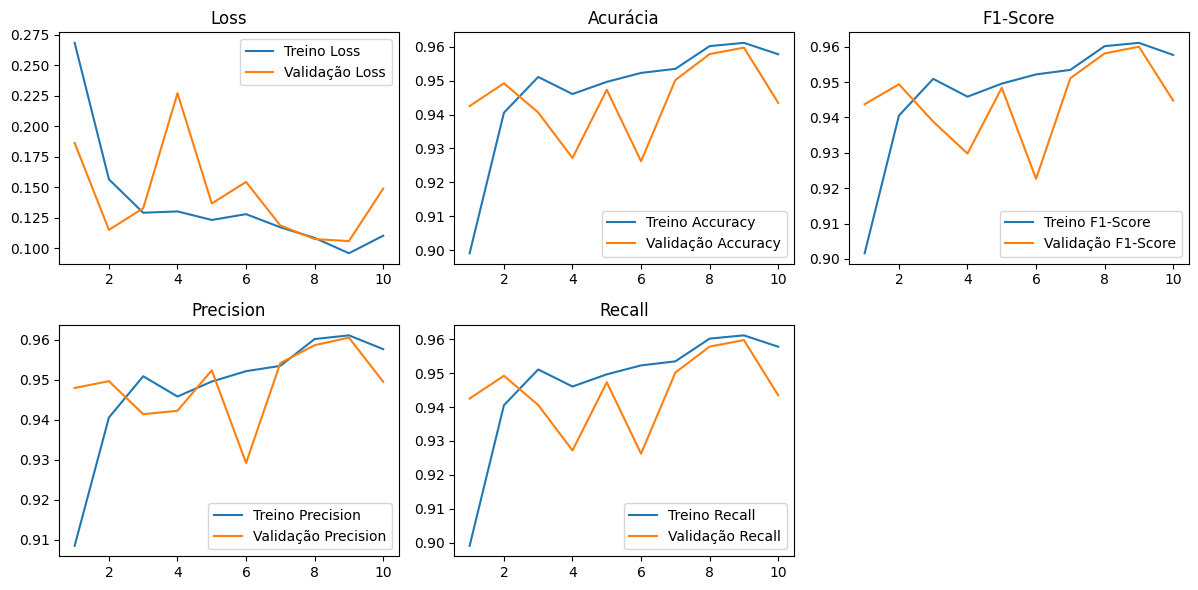

In [45]:
plot_metrics(history)


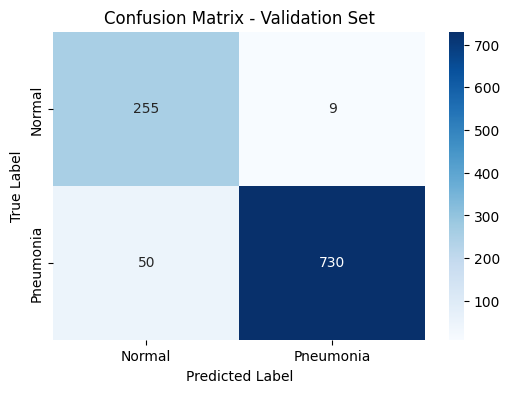

In [46]:
plot_confusion_matrix_validation(model, val_loader, device)


In [47]:
test_loss, test_accuracy, test_f1, test_precision, test_recall = evaluate_model_on_test(model, test_loader, criterion, device)


Teste: Loss: 0.3820, Accuracy: 0.8670, F1-score: 0.8609, Precision: 0.8806, Recall: 0.8670


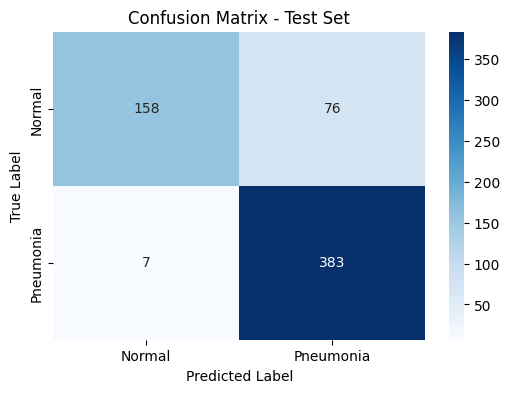

In [48]:
evaluate_and_plot_confusion_matrix(model, test_loader, device)
